훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


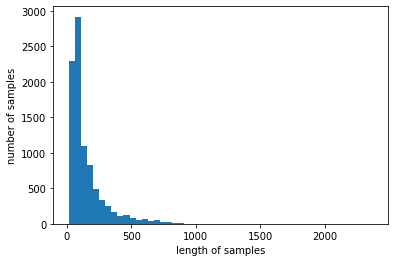

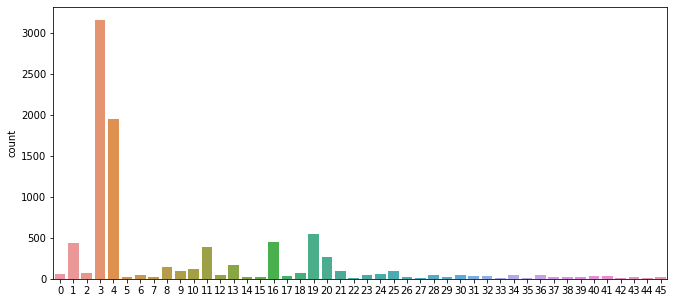

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

In [6]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
#DTM
dtmvector = CountVectorizer()
#TF-IDF
tfidf_transformer = TfidfTransformer()

In [2]:
# word index
word_index = reuters.get_word_index(path="reuters_word_index.json")

#<pad>, <sos>, <unk>
index_to_word = { index+3 : word for word, index in word_index.items() }
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [19]:
## word_num별로 train, test를 가져오고, 단어장을 생성하는 함수

vocab_sizes = [None, 5000, 10000, 15000]

def decode_to_text( text ) :
    decoded_text = []
    for i in range(len( text)):
        t = ' '.join([index_to_word[index] for index in text[i]])
        decoded_text.append(t)
    
    return decoded_text


def load_reuters_by_vocab_sizes():
    
    data_by_vocab = {}

    for size in vocab_sizes:
        (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=size, test_split=0.2)
         
        decoded_train = decode_to_text( x_train )
        decoded_test = decode_to_text( x_test )
        
        # DTM으로 변환
        dtm_train= dtmvector.fit_transform(decoded_train)
        dtm_test = dtmvector.transform(decoded_test) 
        
        #DTM을 TF-IDF 행렬로 변환
        tfidfv_train = tfidf_transformer.fit_transform(dtm_train)
        tfidfv_test = tfidf_transformer.transform(dtm_test) 
        
        data_by_vocab[size] = {
            'x_train': x_train,  #
            'y_train': y_train,
            'x_test': x_test, #
            'y_test': y_test,
            'decoded_train' : decoded_train, #
            'decoded_test' : decoded_test,  #
            'tfidfv_train' : tfidfv_train, 
            'tfidfv_test' : tfidfv_test
        }

    return data_by_vocab

data_by_vocab = load_reuters_by_vocab_sizes()

In [20]:
print(data_by_vocab.keys())

def summarize_data_structure(data_by_vocab):
    """
    data_by_vocab의 구조를 요약해서 자동으로 출력하는 함수.
    각 vocab_size에 대해 훈련 데이터와 테스트 데이터의 크기 및 희소 행렬의 형태를 출력합니다.
    """
    for vocab_size, data in data_by_vocab.items():
        print(f"Vocab Size: {vocab_size}")
        
        # 훈련 데이터 크기
        train_data = data.get('tfidfv_train', None)
        if train_data is not None:
            print(f"  - 훈련 데이터 크기 (행, 열): {train_data.shape}")
            print(f"  - 훈련 데이터 문서 수: {train_data.shape[0]}")
        
        # 테스트 데이터 크기
        test_data = data.get('tfidfv_test', None)
        if test_data is not None:
            print(f"  - 테스트 데이터 크기 (행, 열): {test_data.shape}")
            print(f"  - 테스트 데이터 문서 수: {test_data.shape[0]}")
        
        print("-" * 40)

# 예시 사용법
summarize_data_structure(data_by_vocab)

dict_keys([None, 5000, 15000])
Vocab Size: None
  - 훈련 데이터 크기 (행, 열): (8982, 26506)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 26506)
  - 테스트 데이터 문서 수: 2246
----------------------------------------
Vocab Size: 5000
  - 훈련 데이터 크기 (행, 열): (8982, 4867)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 4867)
  - 테스트 데이터 문서 수: 2246
----------------------------------------
Vocab Size: 15000
  - 훈련 데이터 크기 (행, 열): (8982, 14227)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 14227)
  - 테스트 데이터 문서 수: 2246
----------------------------------------


In [27]:
test_results = []

ml_model_list = ["MultinomialNB", 
                 "ComplementNB"]

def ML_ModelTest() :
   for model_name in ml_model_list: 
       for vocab_size, data in data_by_vocab.items():
            
            print(f"== ModelName: {model_name}, Vocab Size: {vocab_size}")
        
            tfidfv_train = data.get('tfidfv_train', None)
            tfidfv_test = data.get('tfidfv_test', None)
            y_train = data.get('y_train', None)
            y_test = data.get('y_test', None)
        
            if tfidfv_train is not None and tfidfv_test is not None:
                # 1. 나이브 베이즈 분류기
                # 모델 네임별 처리 
                if model_name == "MultinomialNB":
                    model = MultinomialNB()
                elif model_name == "ComplementNB":
                    model = ComplementNB()
                else:
                    raise ValueError(f"Unknown model name: {model_name}")
            
                #훈련
                model.fit(tfidfv_train, y_train) 
                #테스트 데이터에 대한 예측
                predicted = model.predict(tfidfv_test) 
                #예측값과 실제값 비교
                accuracy =  accuracy_score(y_test, predicted)
                # 분류 성능 평가 (classification_report)
                cr = classification_report(y_test, predicted, zero_division=0, output_dict=True)
        
                print("정확도:", accuracy)
                print("F1-Score:", cr['weighted avg']['f1-score'])
        
        
                test_results.append({
                    'model': model_name, 
                    'vocab_size': vocab_size,
                    'val_accuracy': round(accuracy, 4),
                    'f1_score': round(cr['weighted avg']['f1-score'], 4)
                })

ML_ModelTest()
            
# 결과 출력
for result in test_results:
    print(result)     

== ModelName: MultinomialNB, Vocab Size: None
정확도: 0.5997328584149599
F1-Score: 0.5045670886188423
== ModelName: MultinomialNB, Vocab Size: 5000
정확도: 0.6731967943009796
F1-Score: 0.6012501291711391
== ModelName: MultinomialNB, Vocab Size: 15000
정확도: 0.6331255565449688
F1-Score: 0.5498212868794679
== ModelName: ComplementNB, Vocab Size: None
정확도: 0.7649154051647373
F1-Score: 0.7346534179503126
== ModelName: ComplementNB, Vocab Size: 5000
정확도: 0.7707034728406055
F1-Score: 0.7458990404916549
== ModelName: ComplementNB, Vocab Size: 15000
정확도: 0.7720391807658059
F1-Score: 0.7448186439256785
{'model': 'MultinomialNB', 'vocab_size': None, 'val_accuracy': 0.5997, 'f1_score': 0.5046}
{'model': 'MultinomialNB', 'vocab_size': 5000, 'val_accuracy': 0.6732, 'f1_score': 0.6013}
{'model': 'MultinomialNB', 'vocab_size': 15000, 'val_accuracy': 0.6331, 'f1_score': 0.5498}
{'model': 'ComplementNB', 'vocab_size': None, 'val_accuracy': 0.7649, 'f1_score': 0.7347}
{'model': 'ComplementNB', 'vocab_size': 500